In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
%matplotlib inline
import warnings

plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")

C:\Users\ssp1_\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ssp1_\AppData\Local\Temp\ipykernel_23248\481893341.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-15-2023.csv')

In [3]:
latest_data.head()

FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2023-01-16 04:21:05  33.93911   
1   NaN    NaN            NaN        Albania  2023-01-16 04:21:05  41.15330   
2   NaN    NaN            NaN        Algeria  2023-01-16 04:21:05  28.03390   
3   NaN    NaN            NaN        Andorra  2023-01-16 04:21:05  42.50630   
4   NaN    NaN            NaN         Angola  2023-01-16 04:21:05 -11.20270   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953     207900    7854        NaN     NaN  Afghanistan   
1  20.168300     334037    3596        NaN     NaN      Albania   
2   1.659600     271287    6881        NaN     NaN      Algeria   
3   1.521800      47781     165        NaN     NaN      Andorra   
4  17.873900     105095    1930        NaN     NaN       Angola   

   Incident_Rate  Case_Fatality_Ratio  
0     534.058207             3.777778  
1   11607.373688             1.076527  
2     618.655752             2.536428  
3   61840.419336             0.345326  
4     319.765542             1.836434

In [4]:
confirmed_df.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  209436  209451  209451  
1  334427  334427  334427  334427  334443  334457  
2  271469  271477  271477  271490  271494  271496  
3   47875   47875   47875   47875   47890   47890  
4  105277  105277  105277  105277  105288  105288  

[5 rows x 1147 columns]

In [5]:
confirmed_cols = confirmed_df.keys()
deaths_cols = deaths_df.keys()

In [6]:
confirmed = confirmed_df.loc[:, confirmed_cols[4]:]
deaths = deaths_df.loc[:, deaths_cols[4]:]

In [7]:
confirmed.keys()

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1143)

In [8]:
num_dates = len(confirmed.keys())
ck = confirmed.keys()
dk = deaths.keys()

world_cases = []
total_deaths = [] 
mortality_rate = []


for i in range(num_dates):
    confirmed_sum = confirmed[ck[i]].sum()
    death_sum = deaths[dk[i]].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)

Getting daily increases and moving averages

In [9]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

In [10]:
days_since_1_22 = np.array([i for i in range(len(ck))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

Future forcasting

In [11]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(ck)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [12]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

We are using data from 8/1/2022 to present for the prediction model

In [13]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern), we are using data from 8/1/22 and onwards for the prediction modeling 
days_to_skip = 922
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.07, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. We will show the results in the later section.

In [14]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

In [15]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

In [16]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [18]:
# polynomial regression
from sklearn.preprocessing import StandardScaler
linear_model = LinearRegression(StandardScaler(), fit_intercept=True)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

TypeError: LinearRegression.__init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a pipeline for scaling and regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for normalization
    ('regressor', LinearRegression(fit_intercept=True))  # LinearRegression model
])

# Train the pipeline
pipeline.fit(poly_X_train_confirmed, y_train_confirmed)

# Make predictions
test_linear_pred = pipeline.predict(poly_X_test_confirmed)
linear_pred = pipeline.predict(poly_future_forcast)

# Evaluate the model
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 5510277.092022628
MSE: 31527634551142.08


In [22]:
# Access the LinearRegression step within the pipeline
regressor = pipeline.named_steps['regressor']

# Print the coefficients
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

Coefficients: [[ 0.00000000e+00  3.67965983e+08 -6.07205809e+08  2.66466740e+08]]
Intercept: [6.35052867e+08]


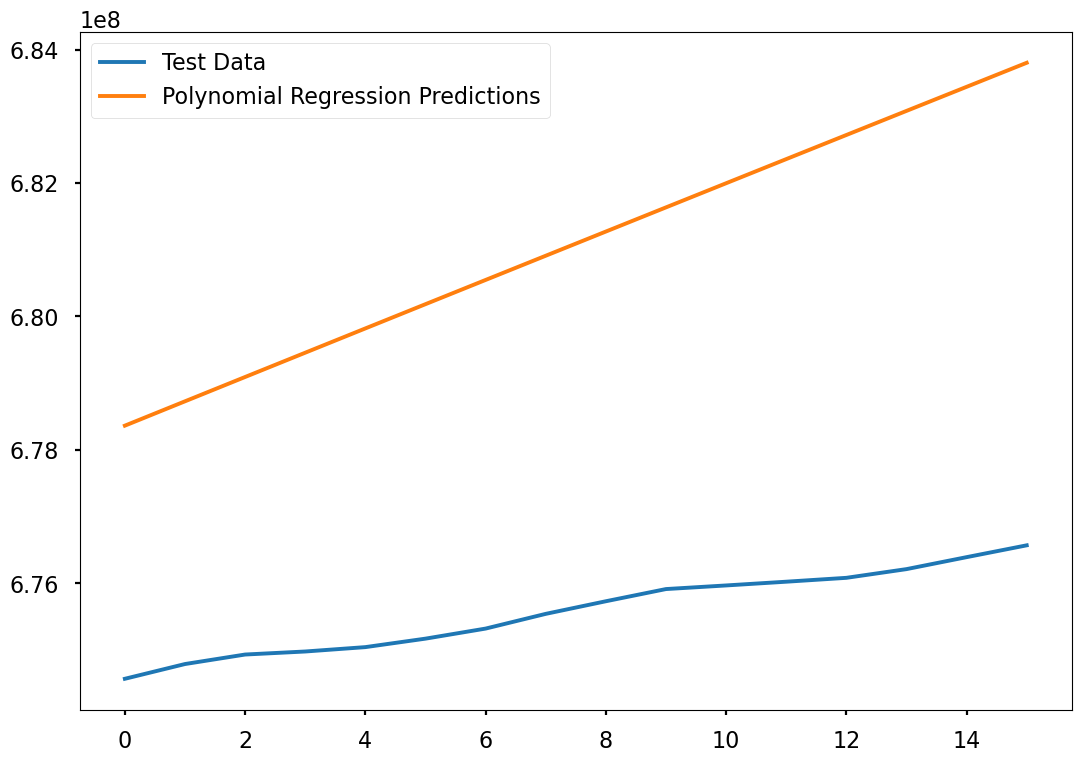

In [23]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV

# Normalize the data using StandardScaler
scaler = StandardScaler()
bayesian_poly_X_train_confirmed_scaled = scaler.fit_transform(bayesian_poly_X_train_confirmed)

# Define hyperparameter grid (exclude 'normalize')
bayesian_grid = {
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
}

# Initialize BayesianRidge model
bayesian = BayesianRidge(fit_intercept=True)

# RandomizedSearchCV
bayesian_search = RandomizedSearchCV(
    estimator=bayesian,
    param_distributions=bayesian_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    n_iter=40,
    verbose=1
)

# Fit the model
bayesian_search.fit(bayesian_poly_X_train_confirmed_scaled, y_train_confirmed)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=BayesianRidge(), n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [26]:
bayesian_search.best_params_

{'tol': 0.001,
 'lambda_2': 0.001,
 'lambda_1': 1e-07,
 'alpha_2': 0.001,
 'alpha_1': 1e-05}

In [27]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 5.237464649895338e+16
MSE: 2.743511145289666e+33


plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

Graphing the number of confirmed cases, deaths, and mortality rate (CFR). This gives us a big picture of the ongoing pandemic.

In [30]:
# helper method for flattening the data, so it can be displayed on a bar graph 
def flatten(arr):
    a = [] 
    arr = arr.tolist()
    for i in arr:
        a.append(i[0])
    return a

In [31]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 8))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [32]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

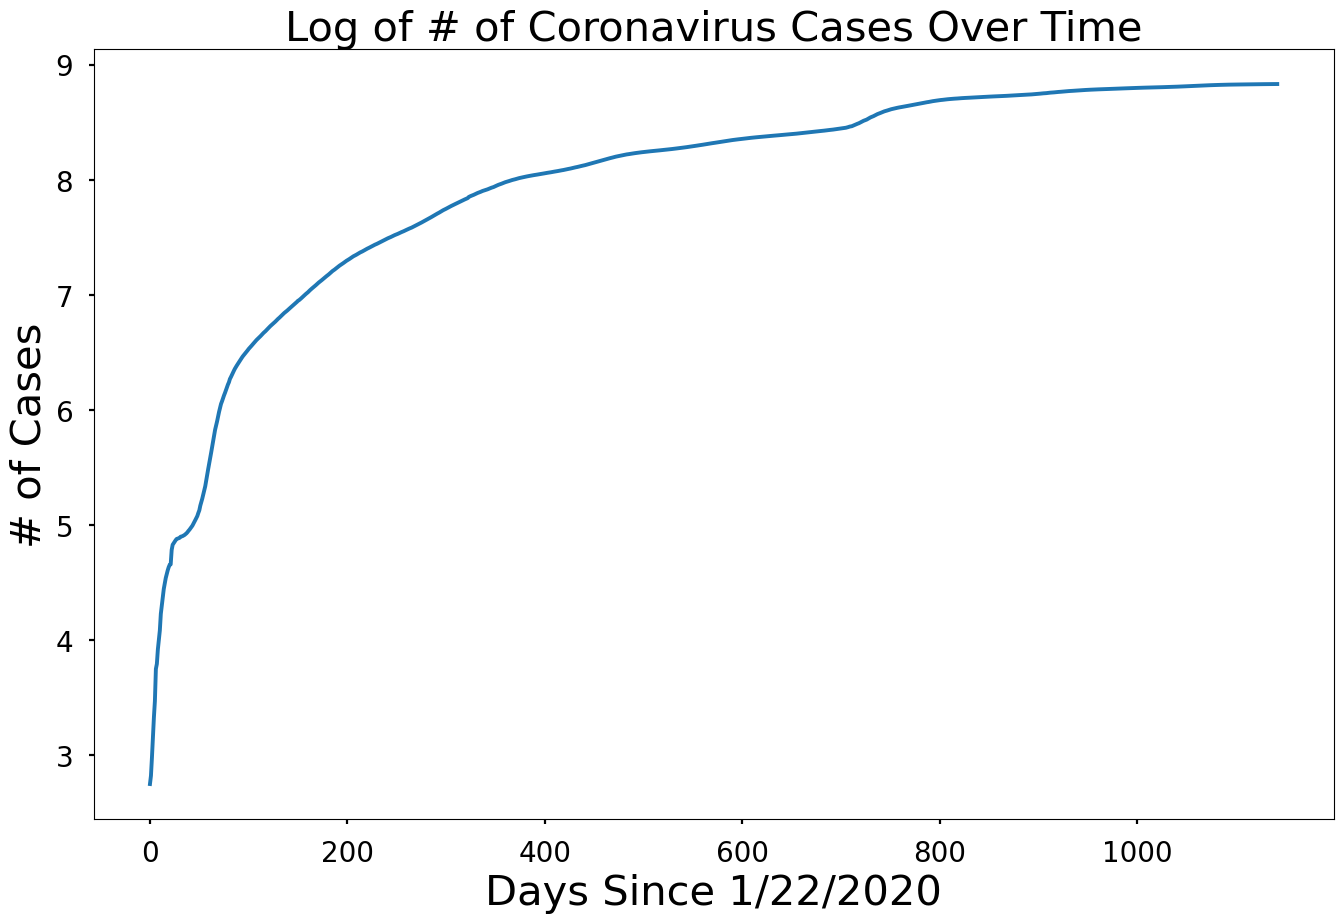

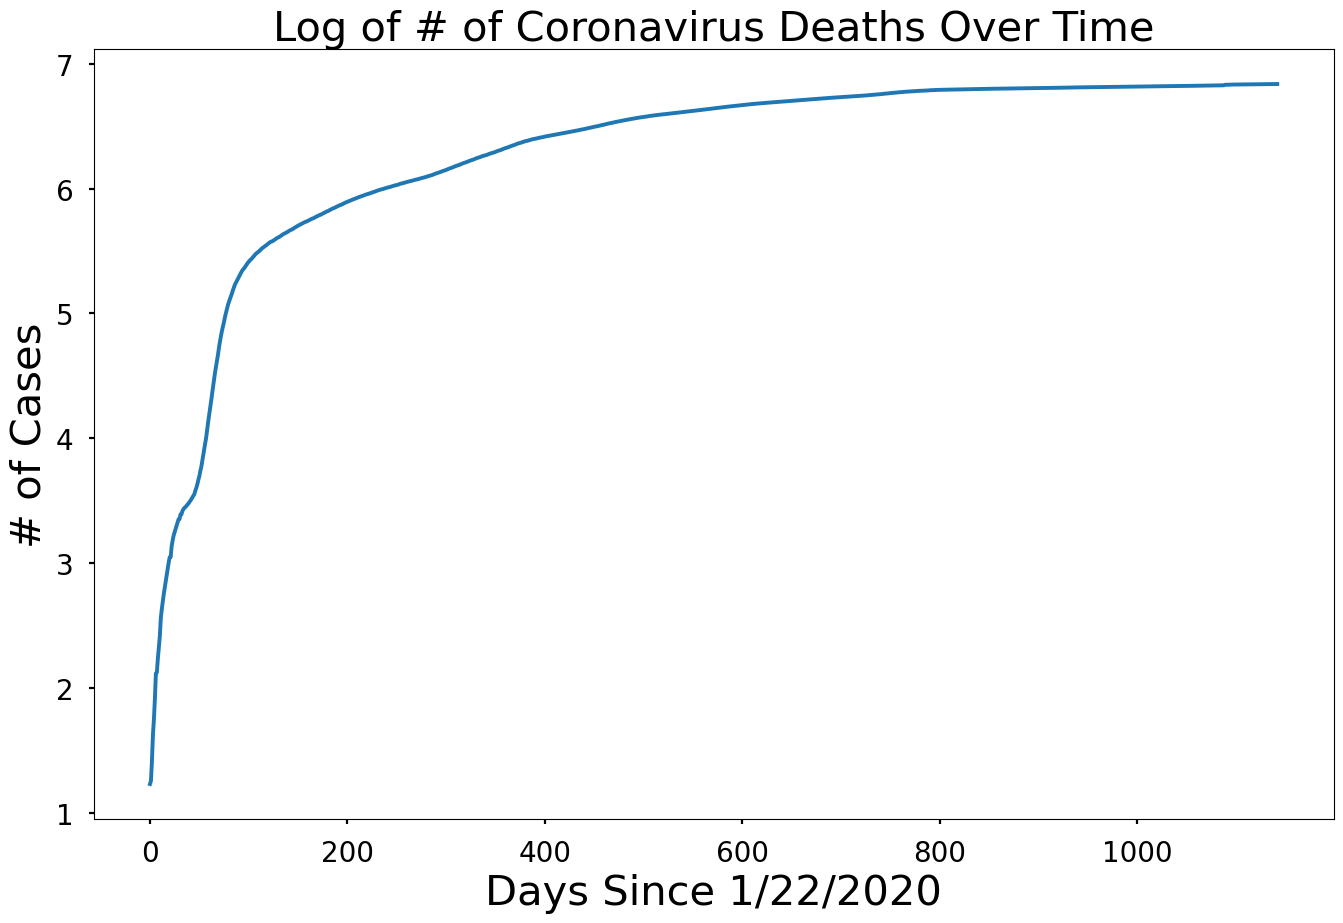

In [33]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [34]:
def country_plot(x, y1, y2, y3, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    SIZE = (12, 8)
    
    plt.figure(figsize=SIZE)
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=SIZE)
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=SIZE)
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


# helper function for getting a country's total covid cases and deaths    
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    
    for i in range(num_dates):
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][ck[i]].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][dk[i]].sum())
    return (country_cases, country_deaths)
    
    
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    
    country_plot(adjusted_dates, country_cases, country_daily_increase, country_daily_death, country_name)
    

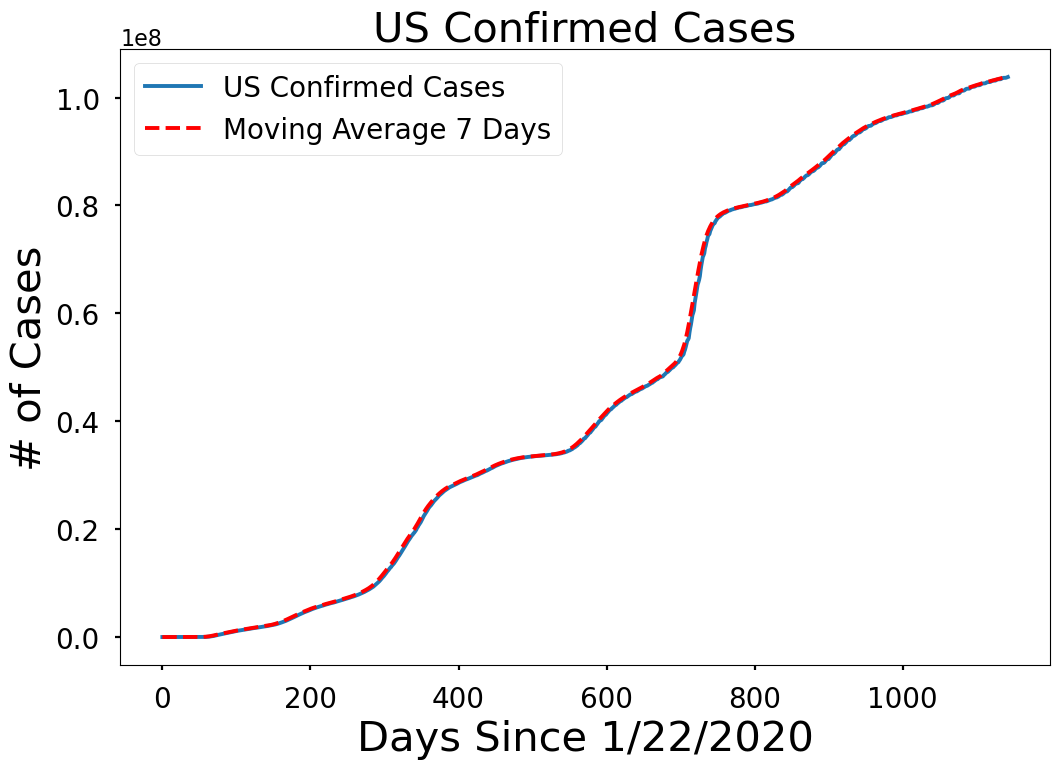

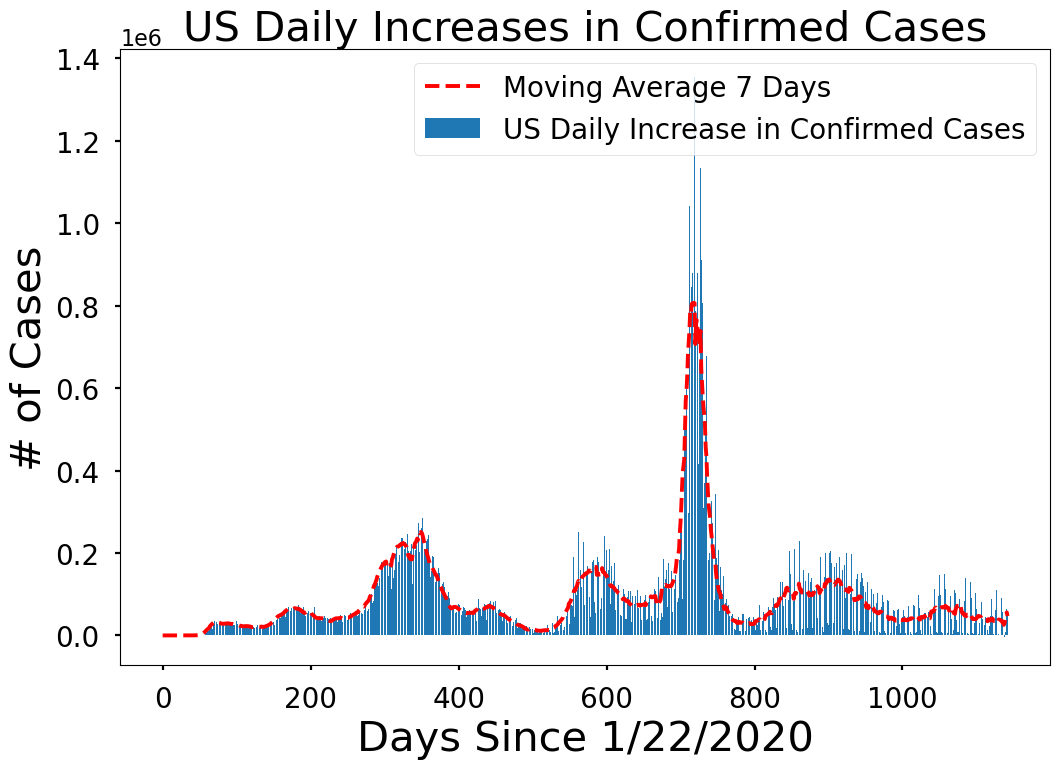

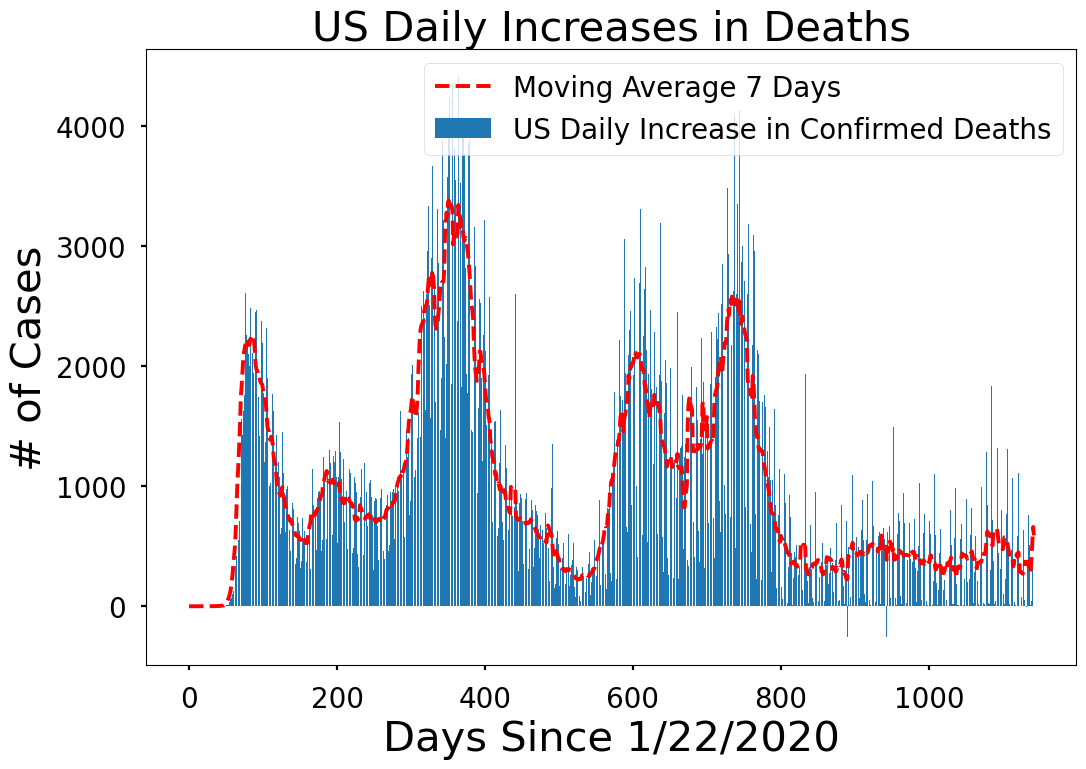

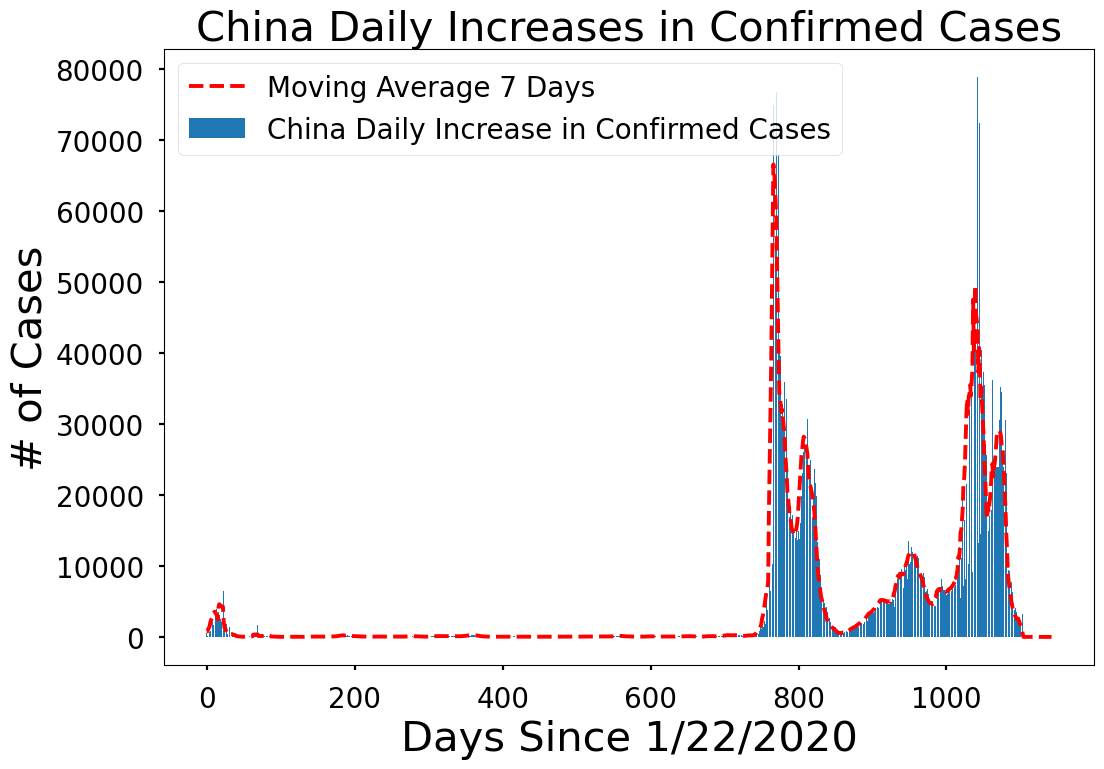

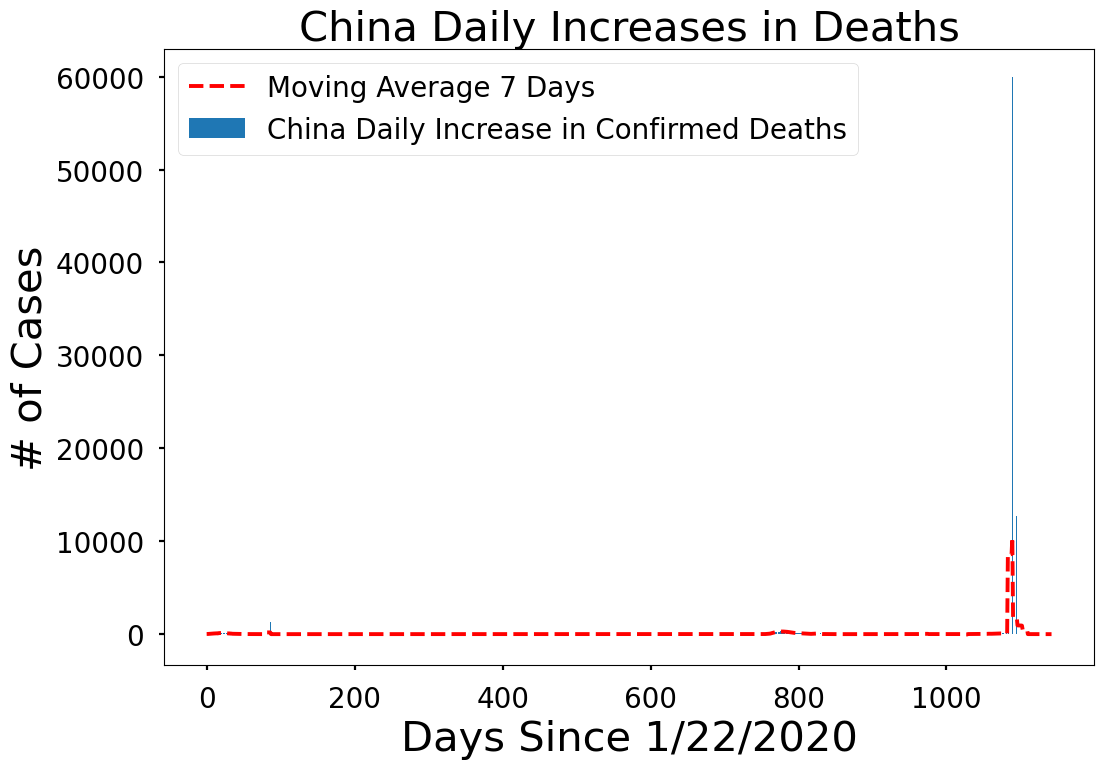

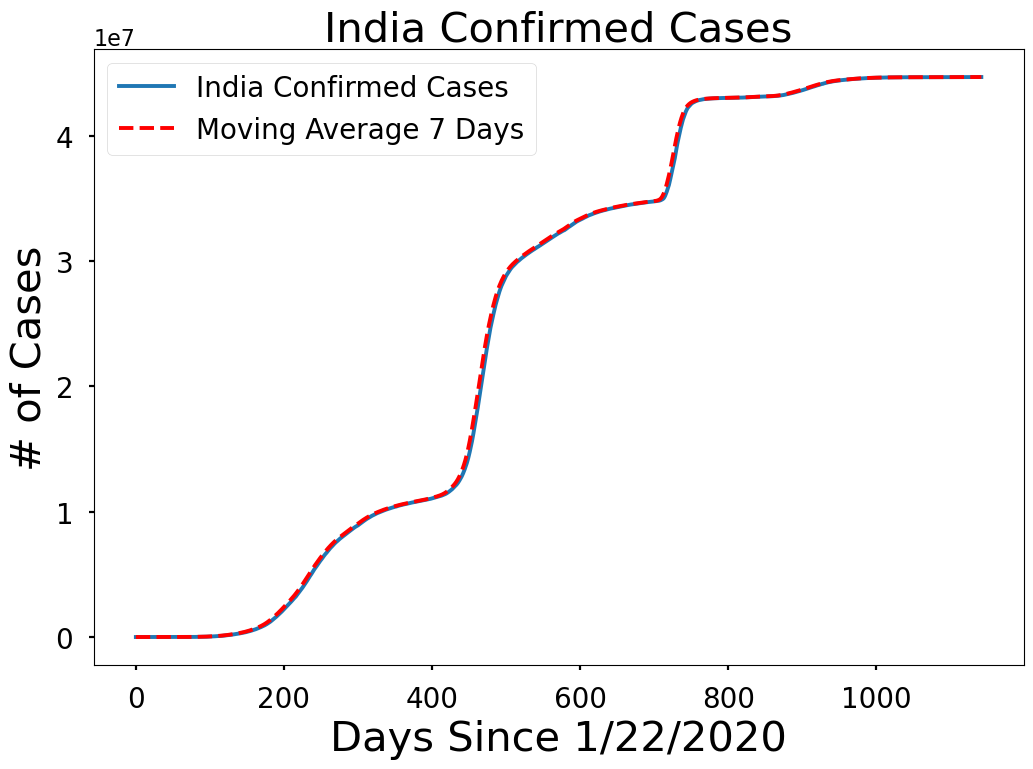

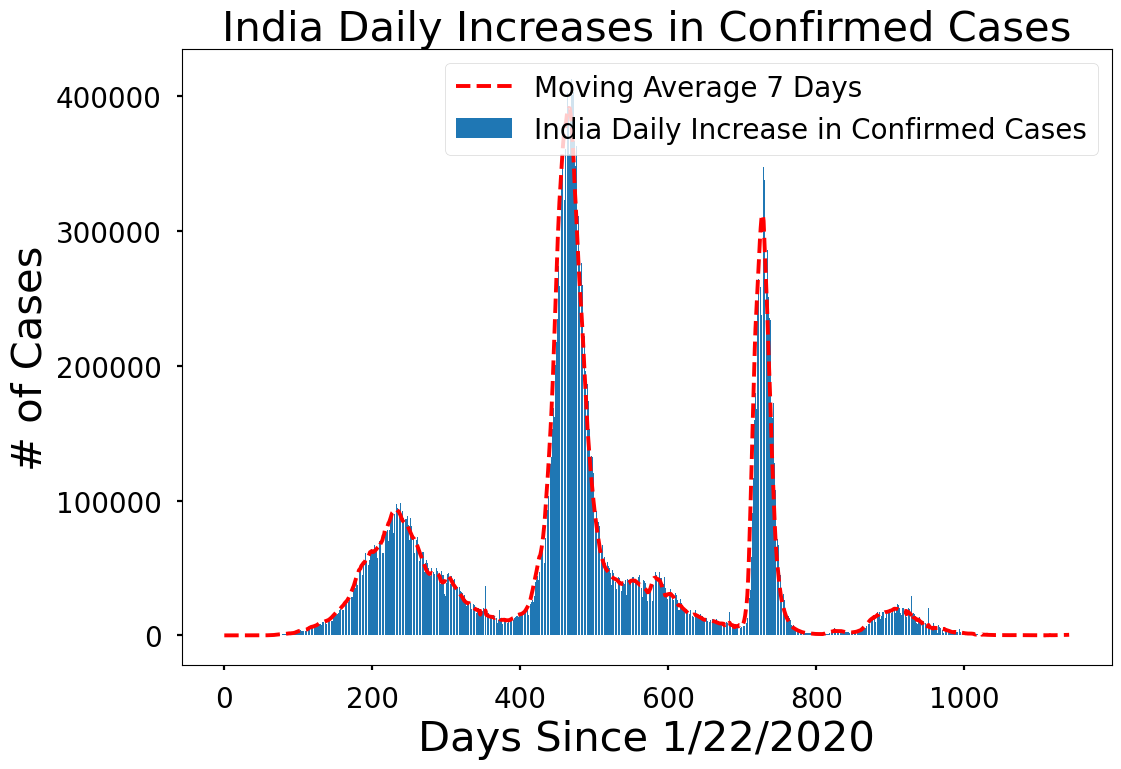

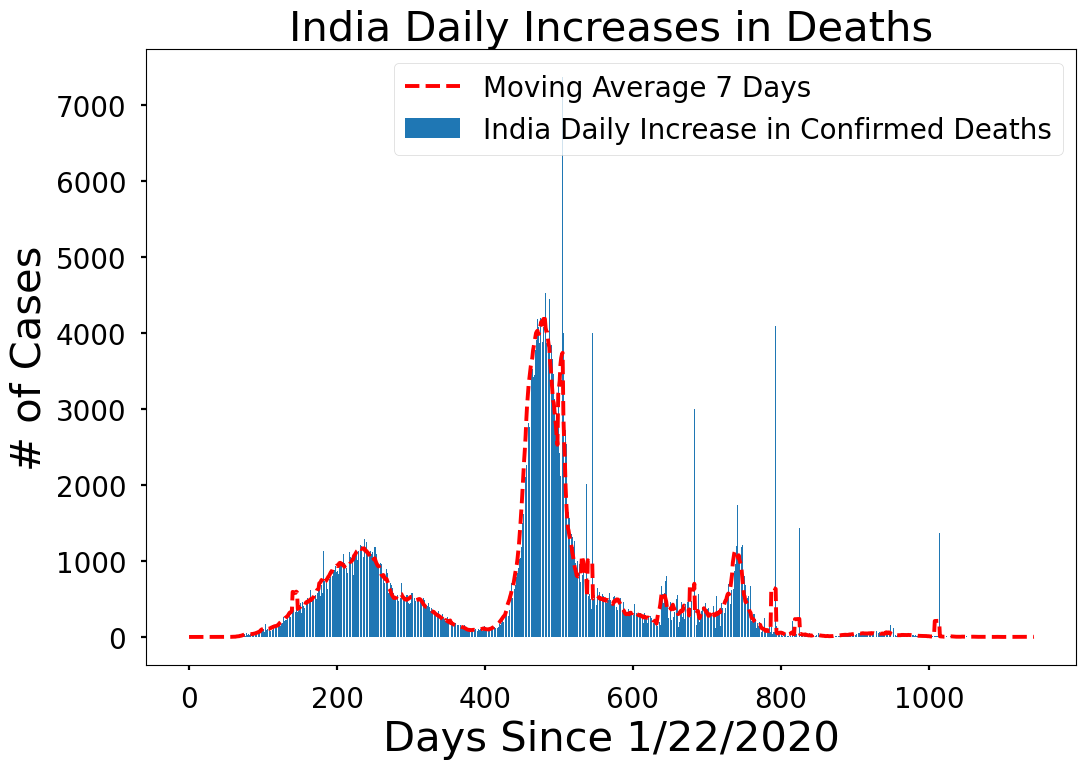

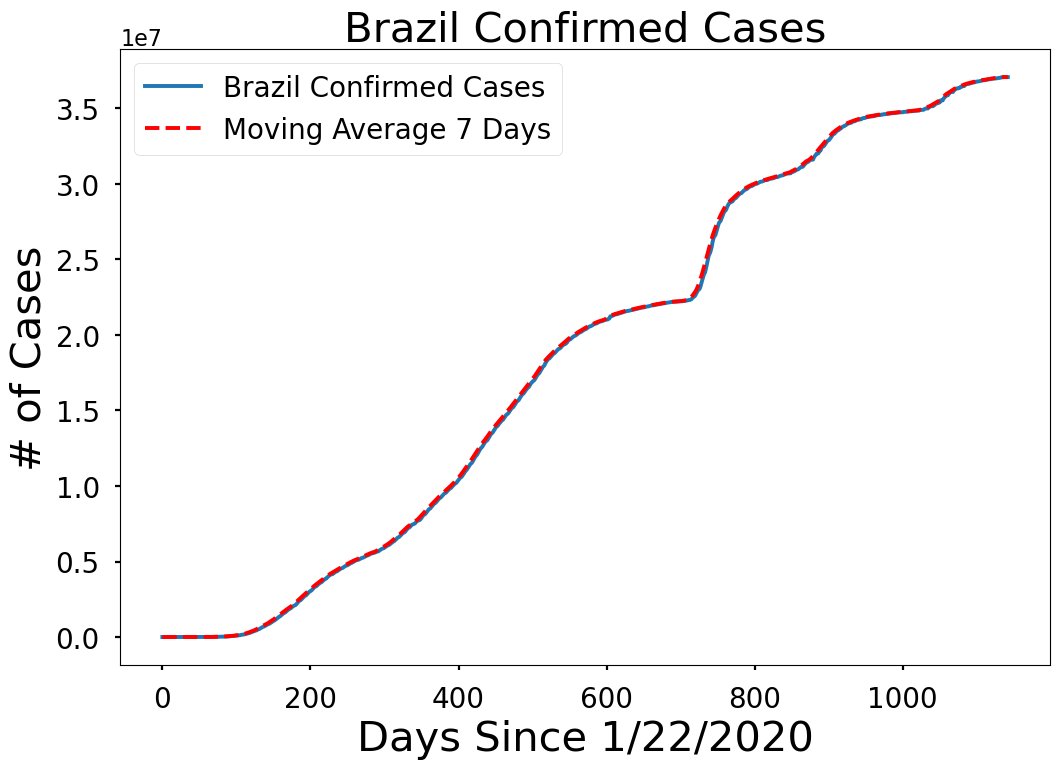

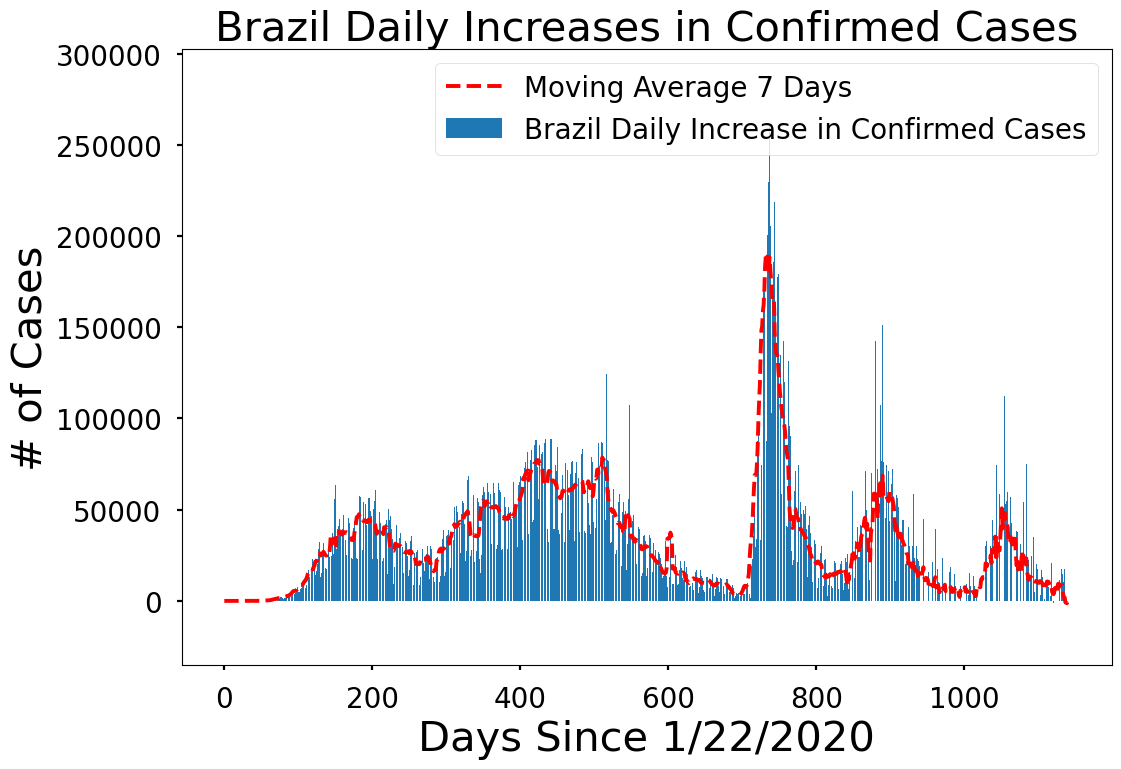

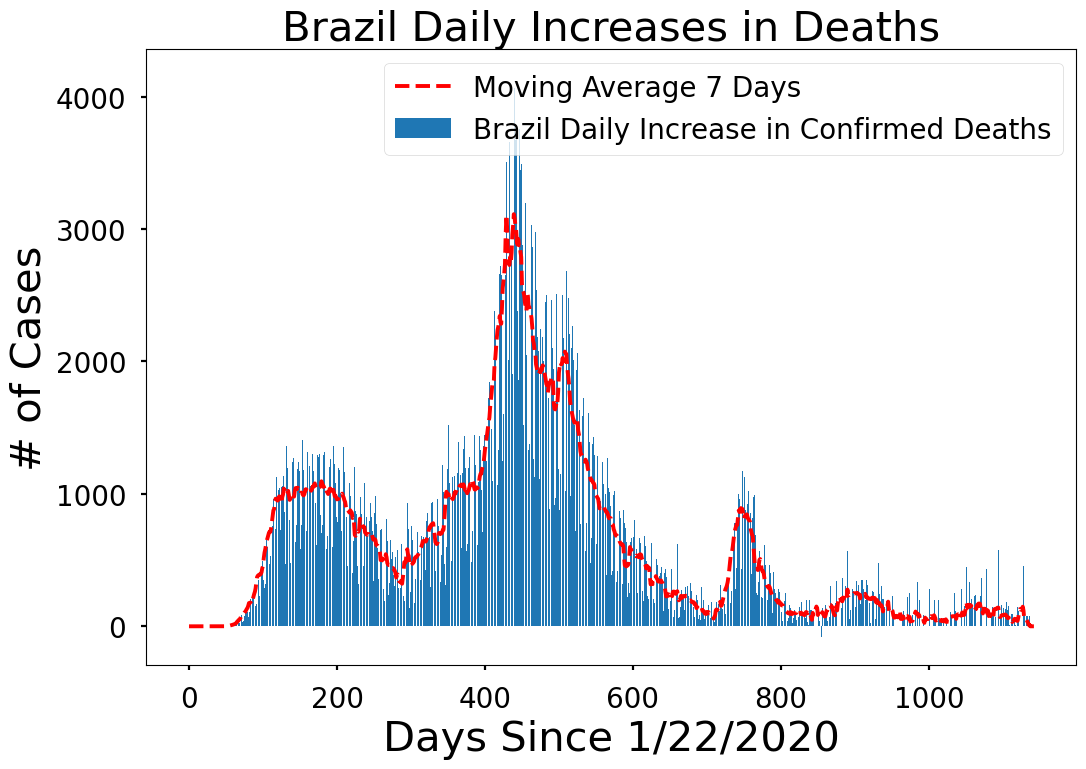

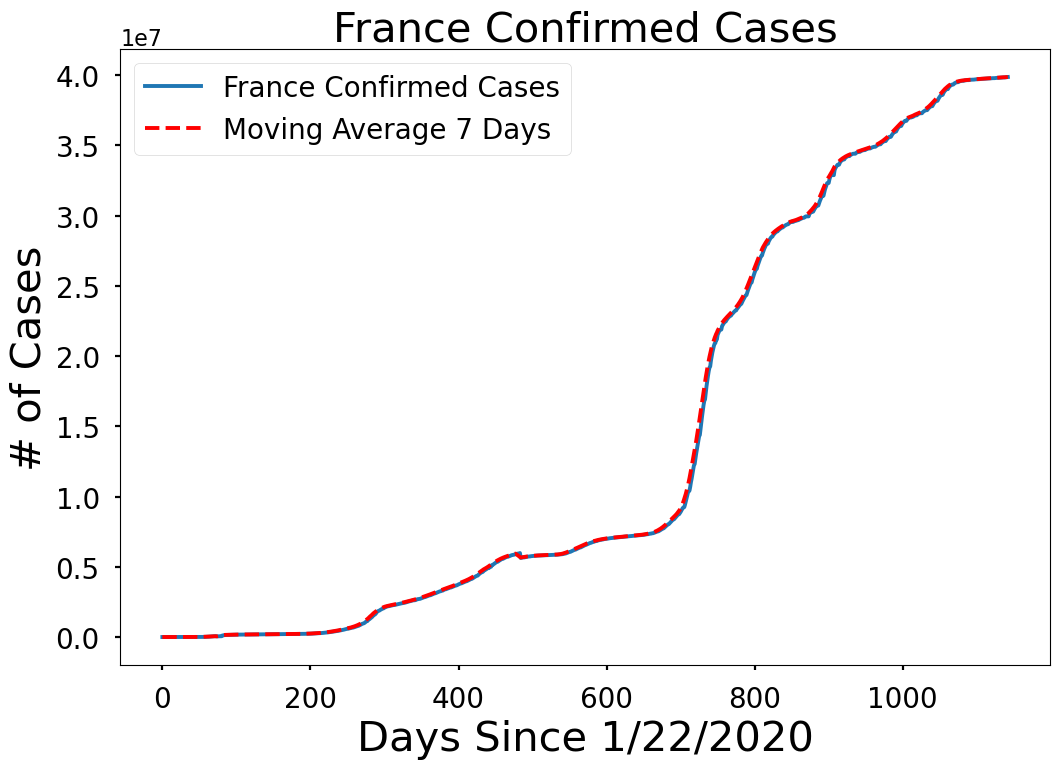

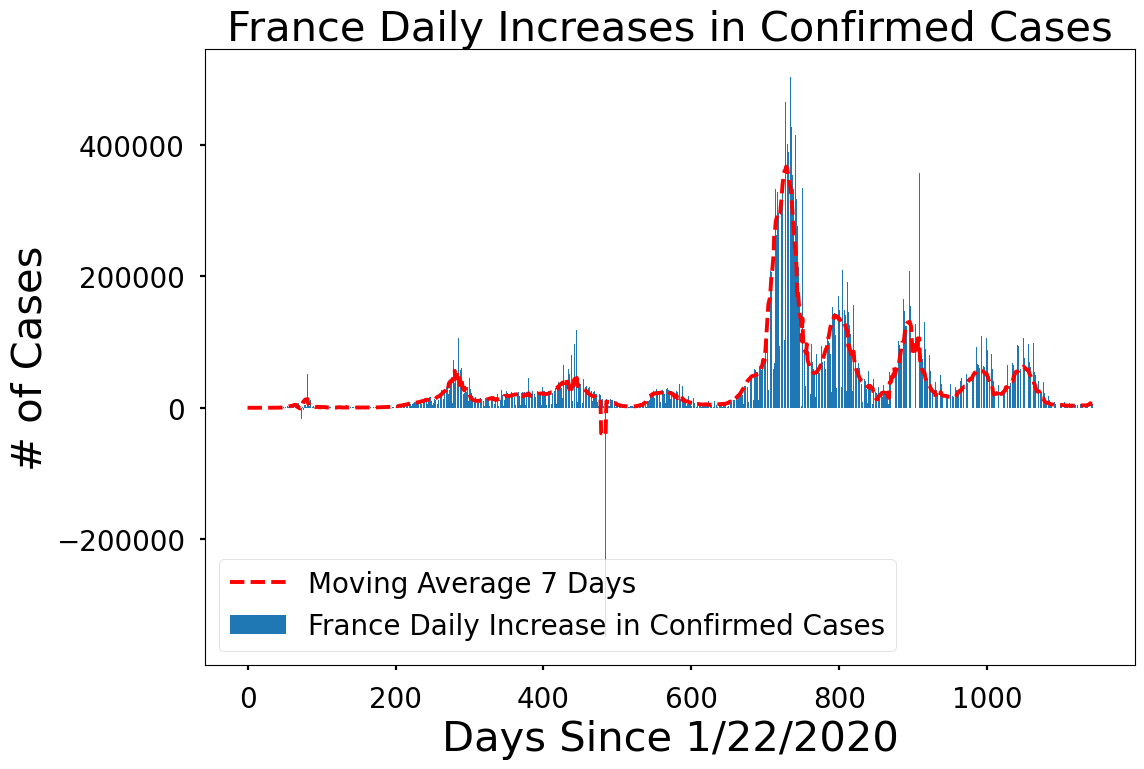

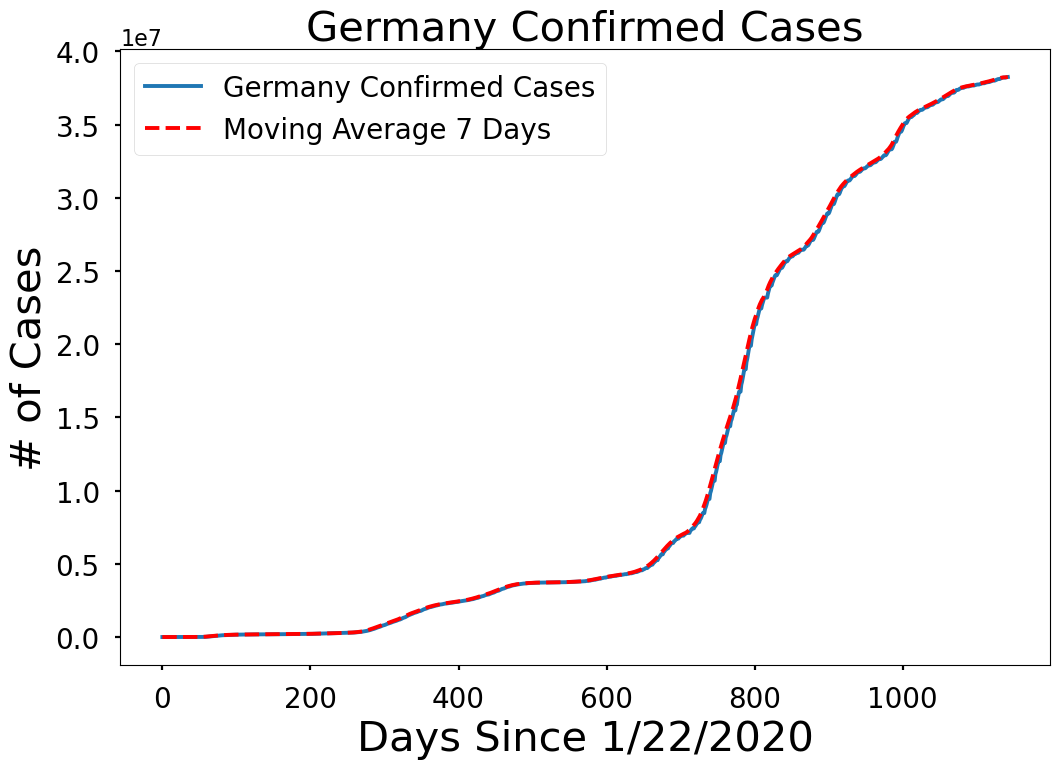

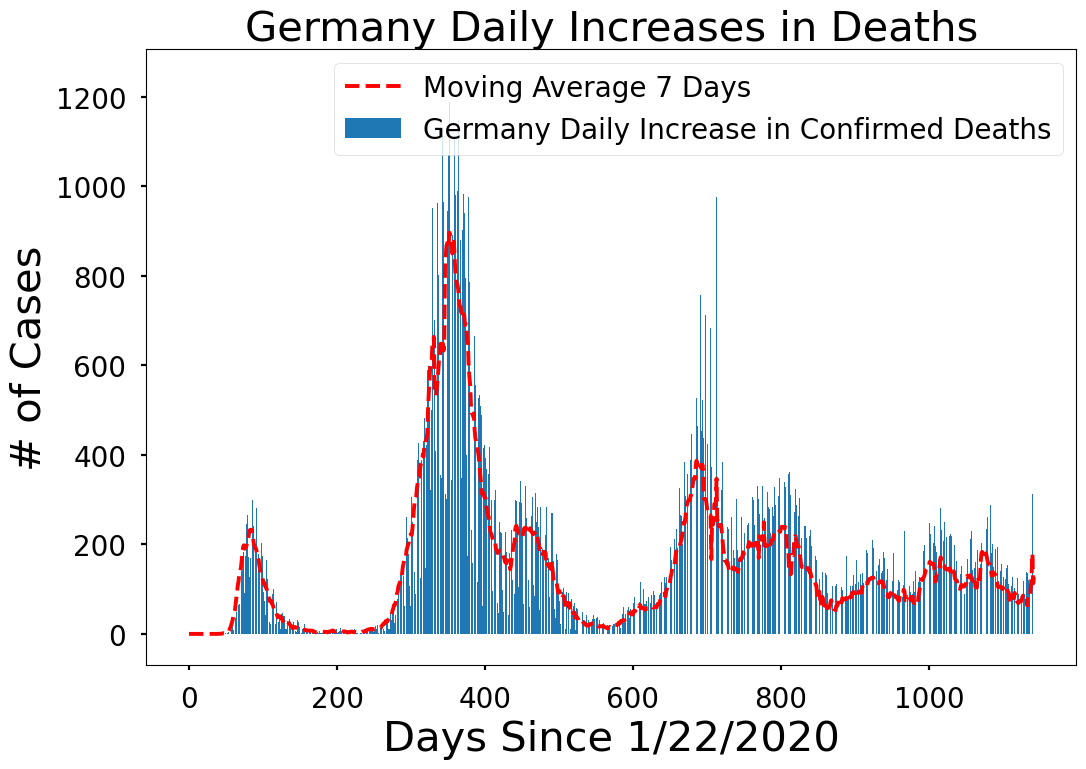

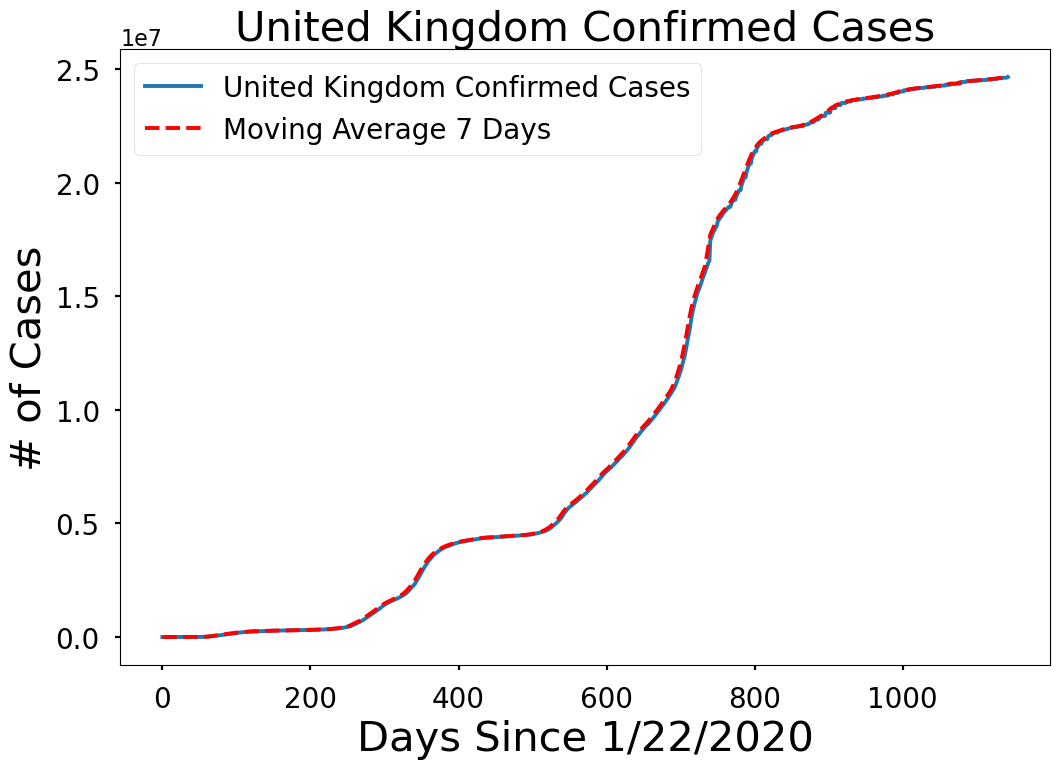

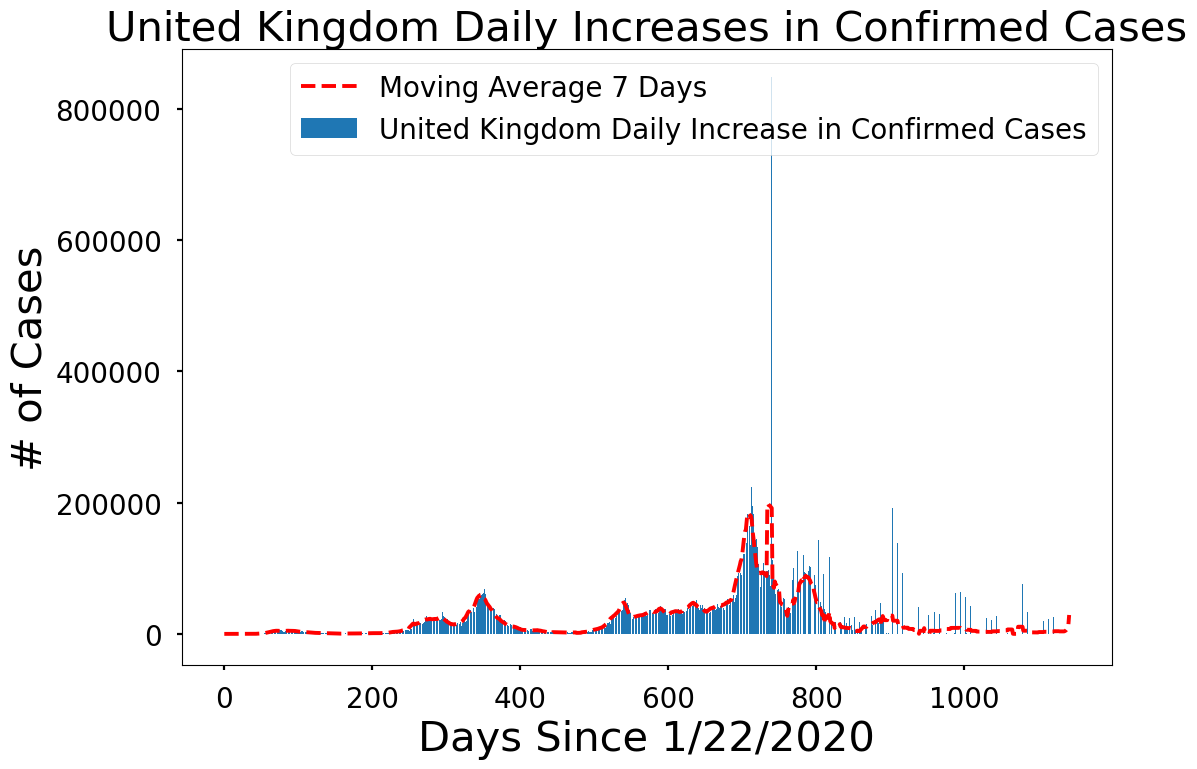

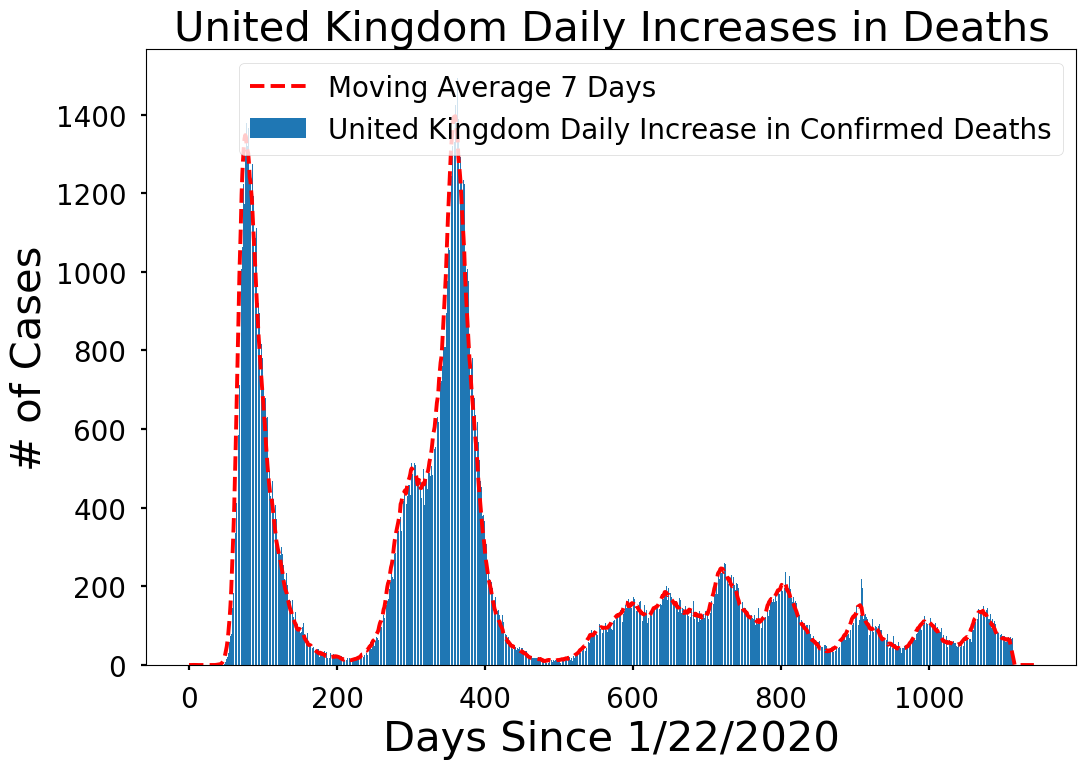

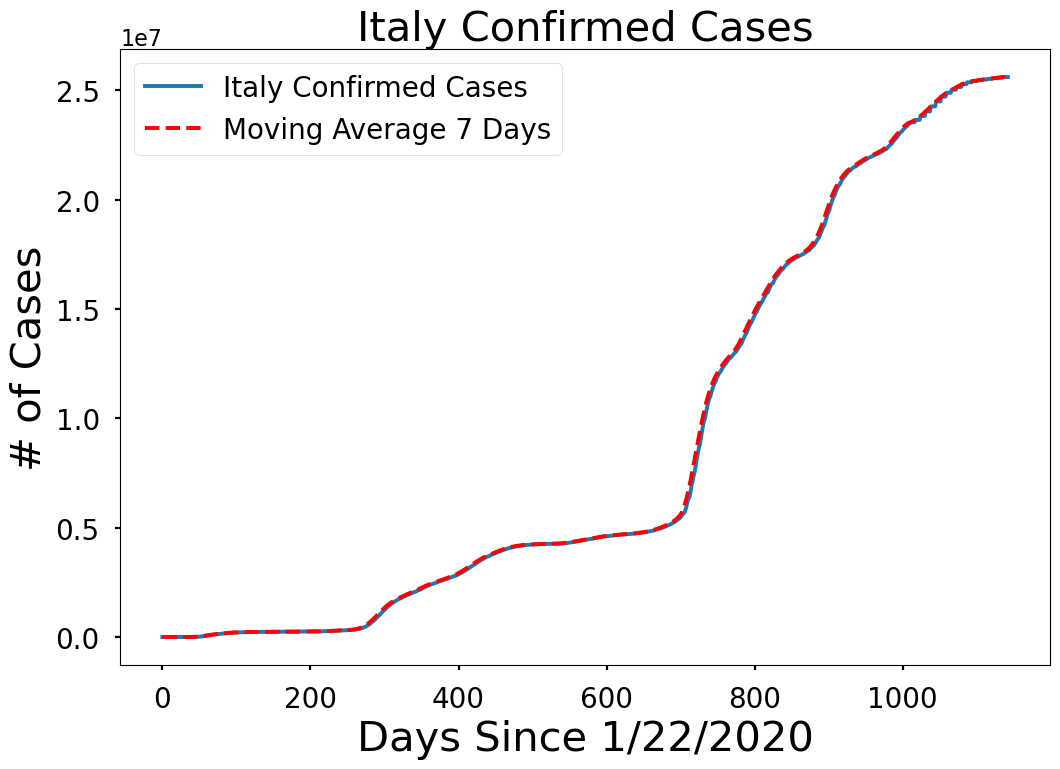

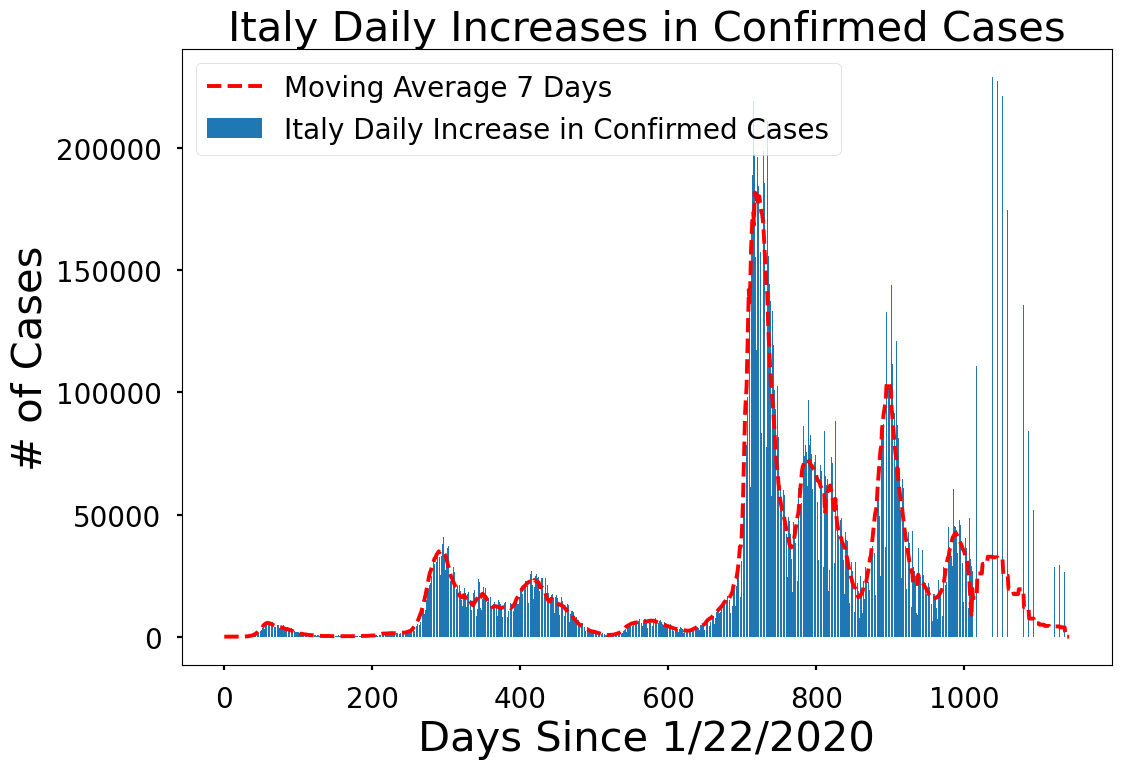

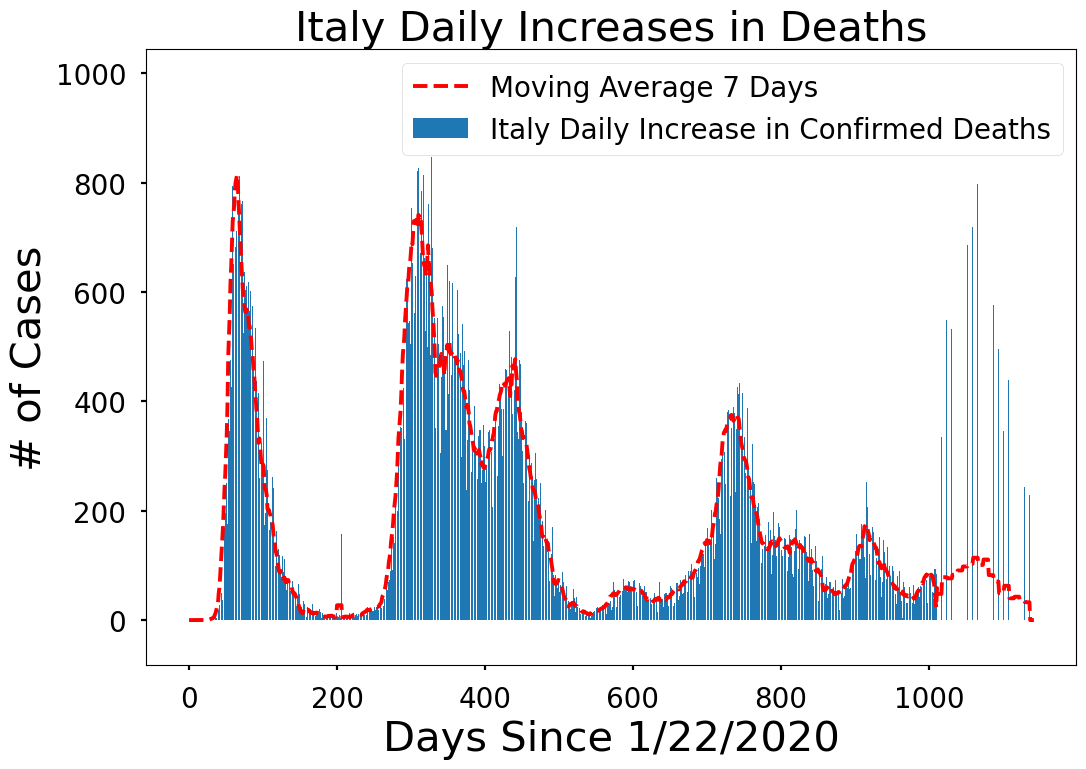

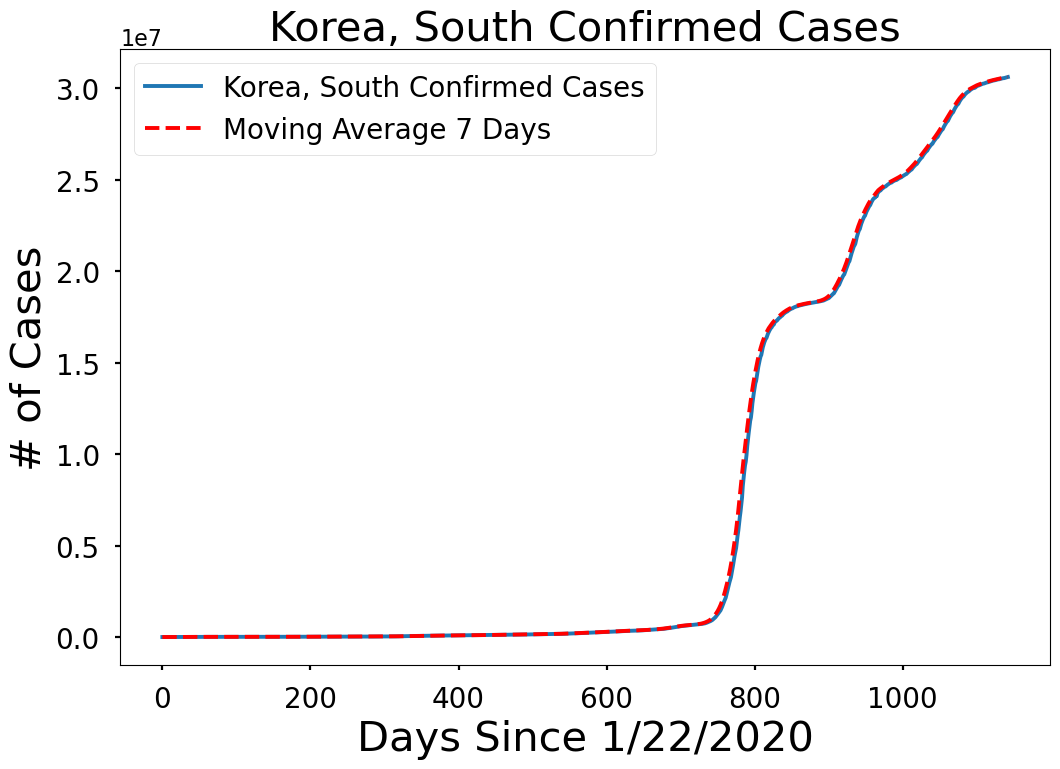

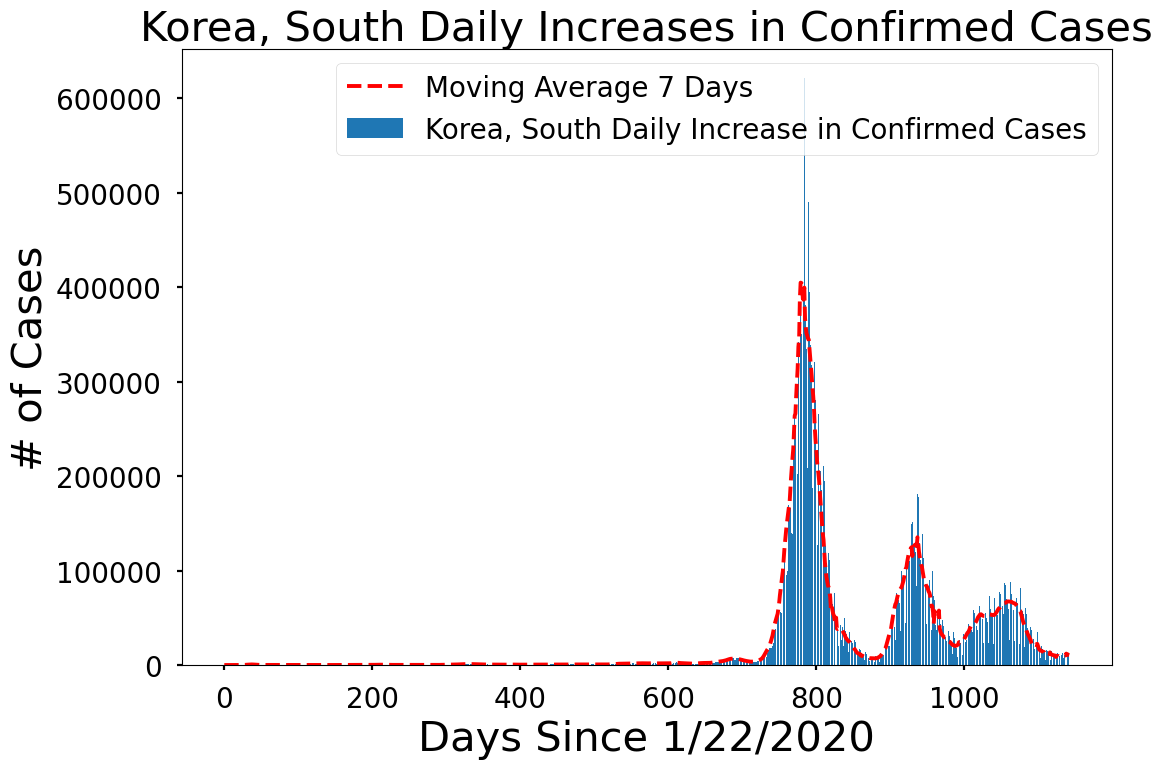

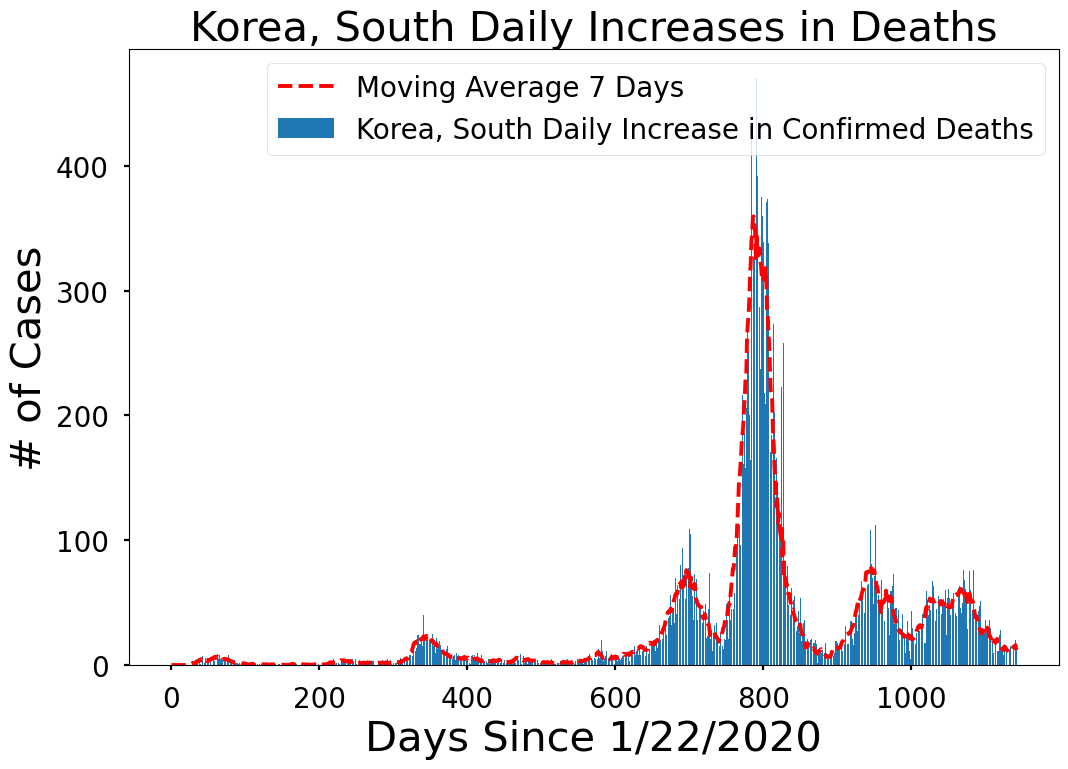

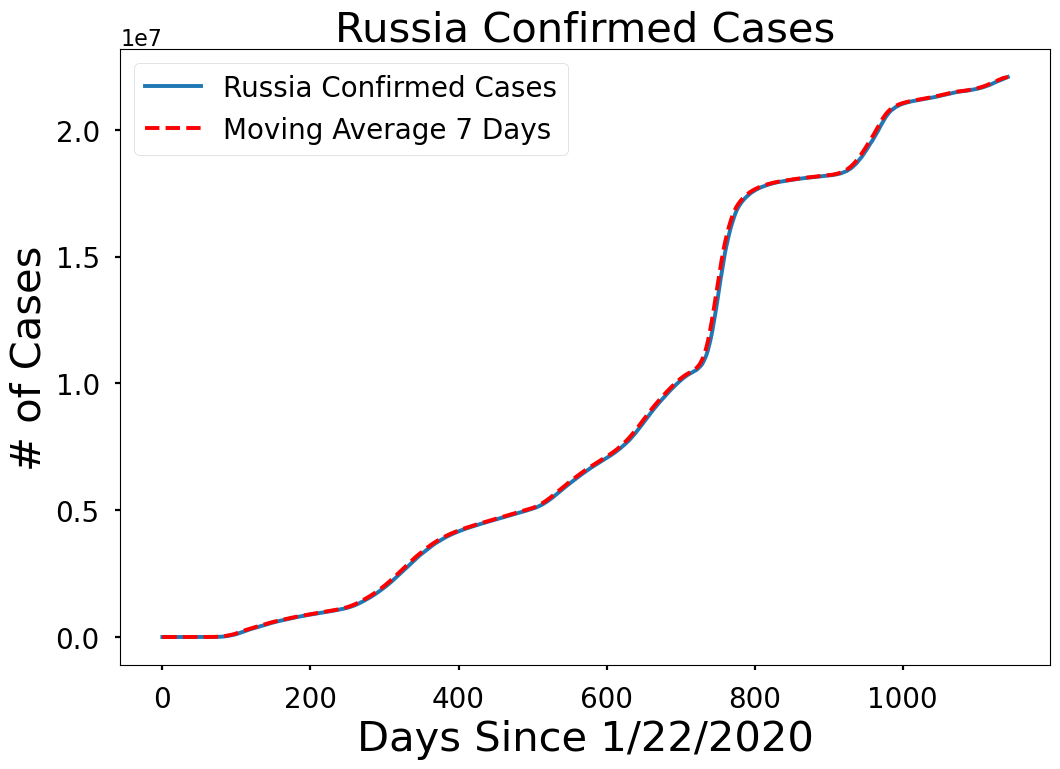

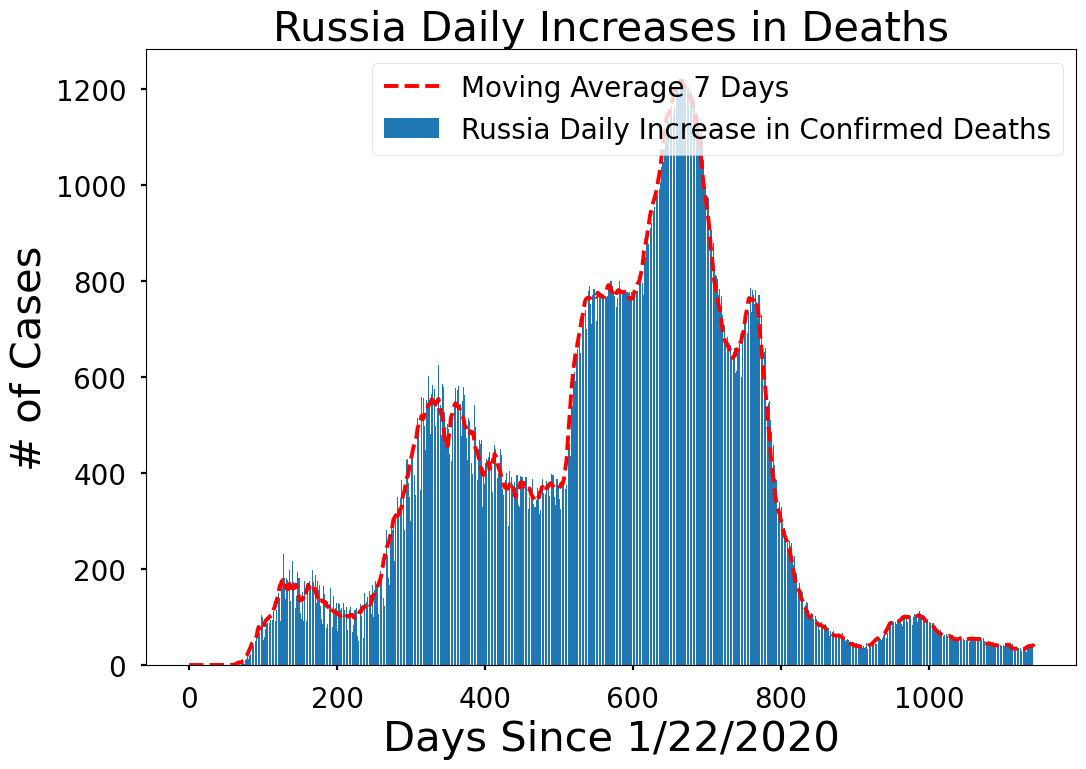

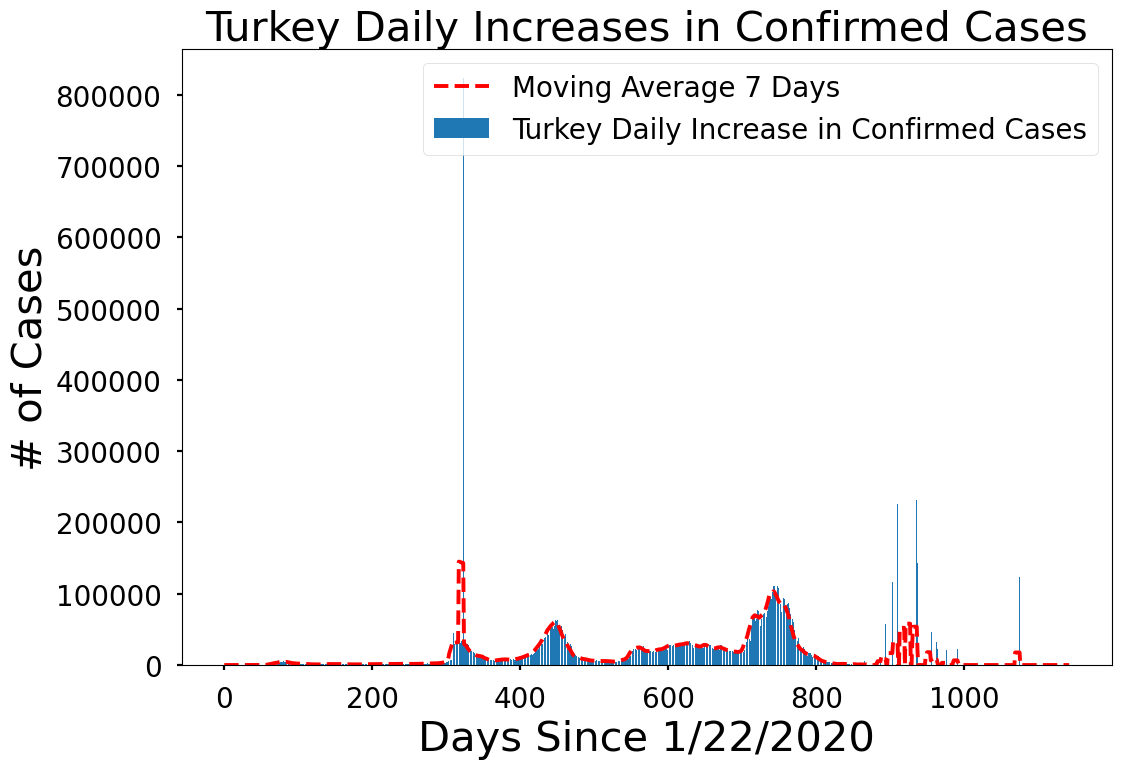

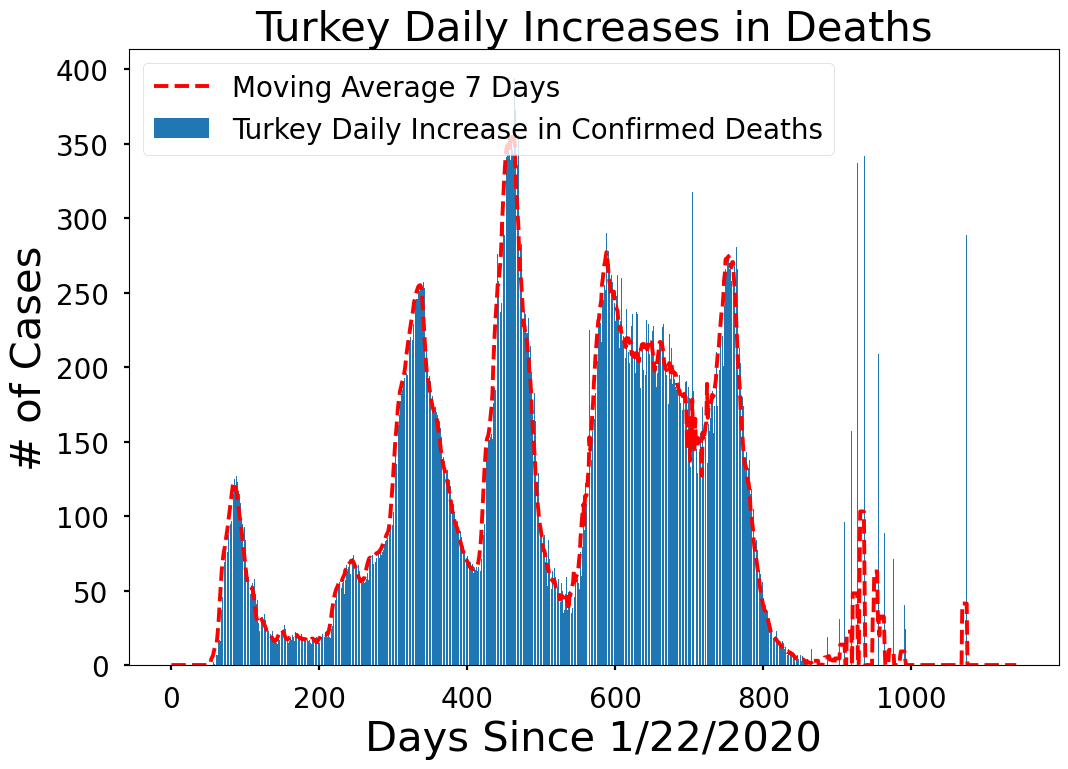

In [35]:
countries = ['US', 'China', 'India', 'Brazil', 'France', 'Germany', 'United Kingdom', 'Italy', 'Korea, South',
             'Russia', 'Turkey']

for country in countries:
    country_visualizations(country)

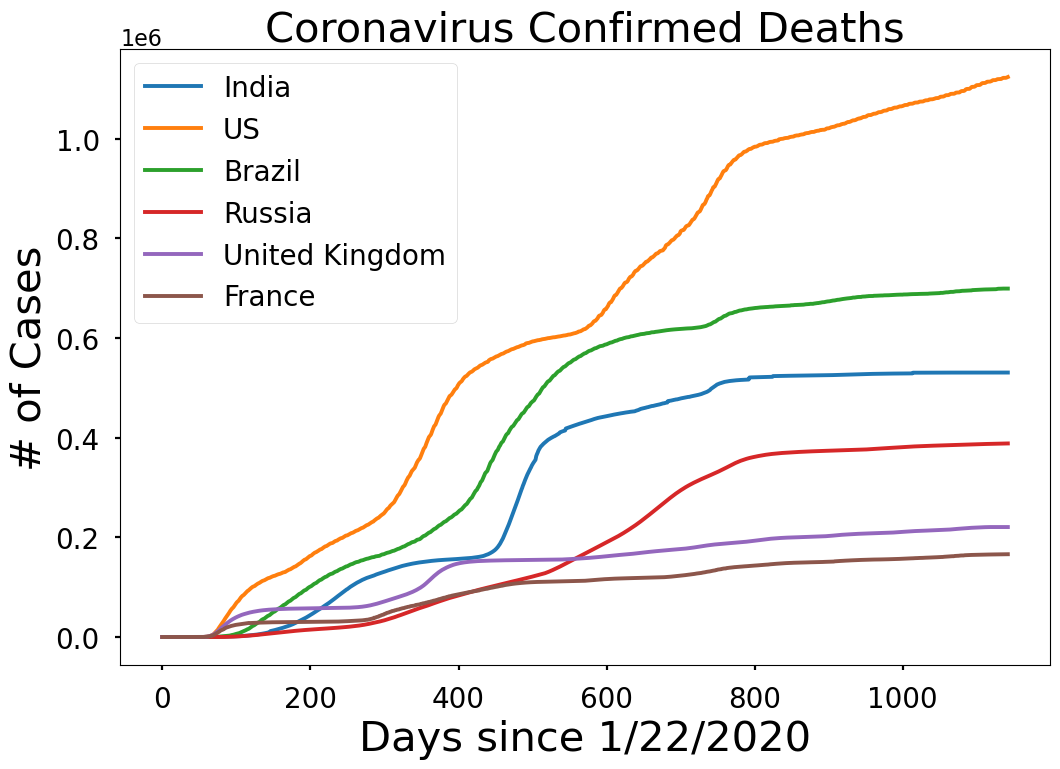

In [36]:
# Country Comparison
# removed redundant code

compare_countries = ['India', 'US', 'Brazil', 'Russia', 'United Kingdom', 'France'] 
graph_name = ['Coronavirus Confirmed Cases', 'Coronavirus Confirmed Deaths']

for num in range(2):
    plt.figure(figsize=(12, 8))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num])
    plt.legend(compare_countries, prop={'size': 20})
    plt.xlabel('Days since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.title(graph_name[num], size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

Predictions for confirmed coronavirus cases worldwide

In [38]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(12, 8))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

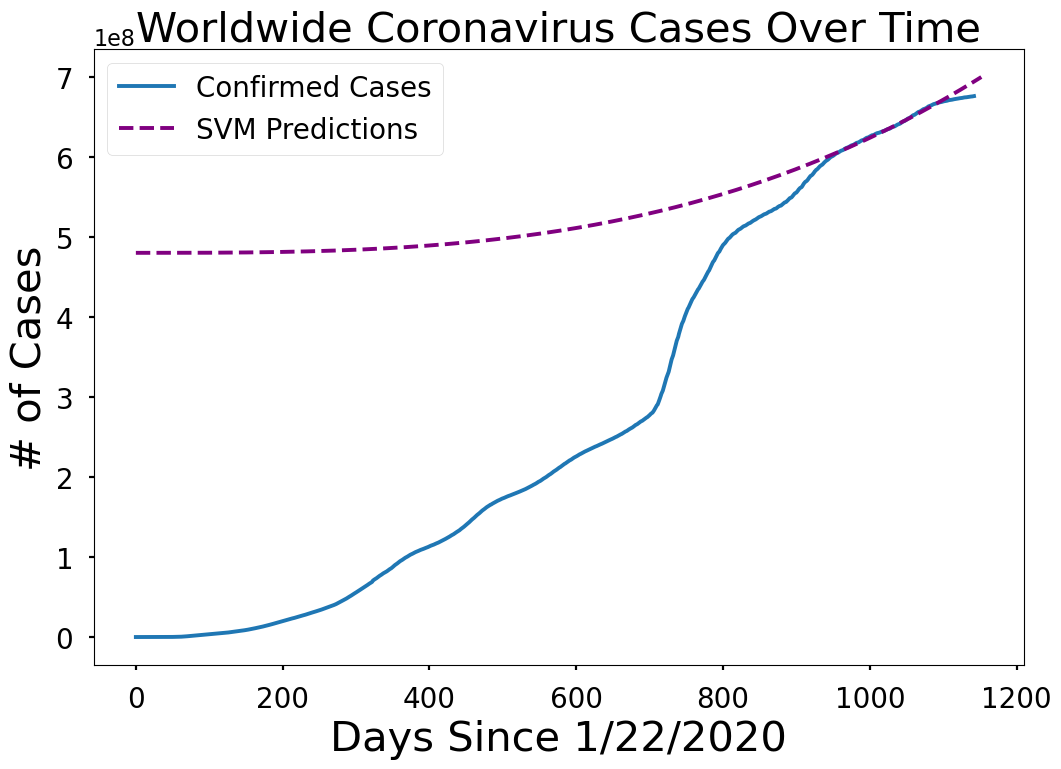

In [39]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

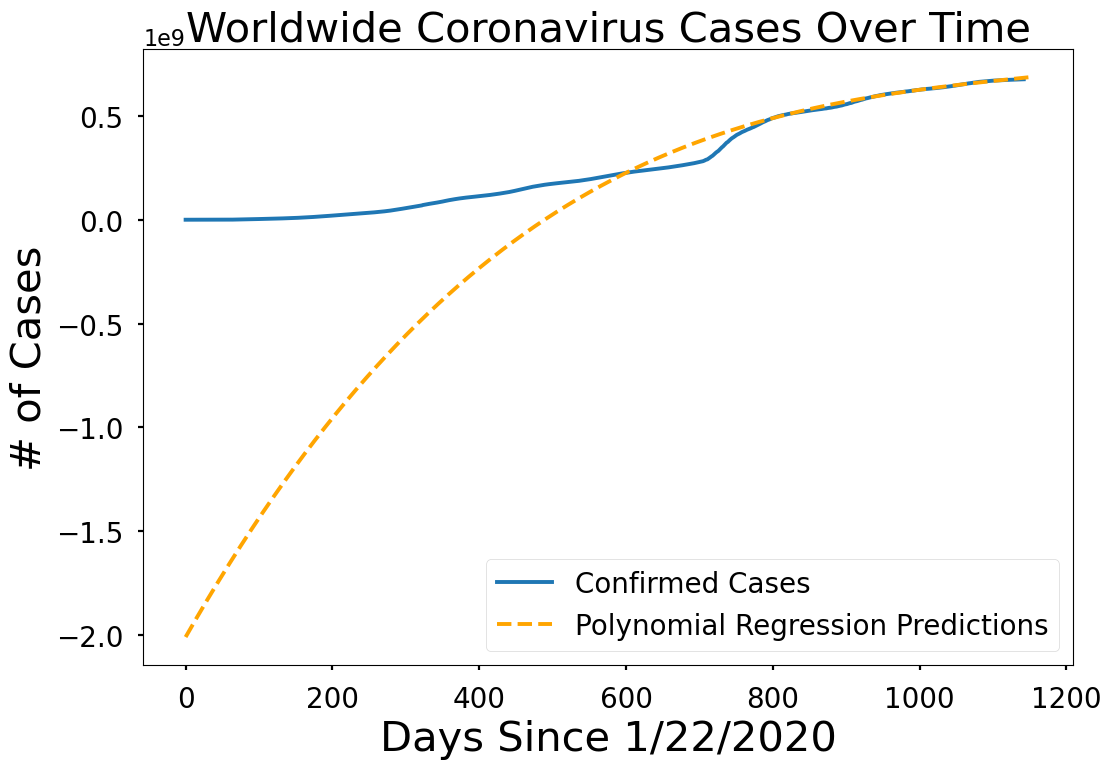

In [40]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [41]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [42]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

In [43]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

In [44]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')

In [45]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [46]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [47]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [48]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in country_confirmed_cases],
                          'Number of Deaths': [format(int(i), ',d') for i in country_death_cases], 
                          'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Oranges')

In [49]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [50]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_incidence_rate = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
#     province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
#     province_active.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Active'].sum())
    province_incidence_rate.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Incident_Rate'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [51]:
# number of cases per province/state/city top 100 
province_limit = 100 
province_df = pd.DataFrame({'Province/State Name': unique_provinces[:province_limit], 'Country': province_country[:province_limit], 'Number of Confirmed Cases': [format(int(i), ',d') for i in province_confirmed_cases[:province_limit]],
                          'Number of Deaths': [format(int(i), ',d') for i in province_death_cases[:province_limit]], 
                        'Incidence Rate' : province_incidence_rate[:province_limit], 'Mortality Rate': province_mortality_rate[:province_limit]})
# number of cases per country/region

province_df.style.background_gradient(cmap='Oranges')

In [52]:
# return the data table with province/state info for a given country
def country_table(country_name):
    states = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    state_confirmed_cases = []
    state_death_cases = [] 
    # state_recovery_cases = []
#     state_active = [] 
    state_incidence_rate = [] 
    state_mortality_rate = [] 

    no_cases = [] 
    for i in states:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            state_confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        state_confirmed_cases[i] = latest_data[latest_data['Province_State']==states[i]]['Confirmed'].sum()
        state_death_cases.append(latest_data[latest_data['Province_State']==states[i]]['Deaths'].sum())
    #     state_recovery_cases.append(latest_data[latest_data['Province_State']==states[i]]['Recovered'].sum())
#         state_active.append(latest_data[latest_data['Province_State']==states[i]]['Active'].sum())
        state_incidence_rate.append(latest_data[latest_data['Province_State']==states[i]]['Incident_Rate'].sum())
        state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in state_confirmed_cases],
                              'Number of Deaths': [format(int(i), ',d') for i in state_death_cases], 
                             'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
    # number of cases per country/region
    return state_df

In [53]:
us_table = country_table('US')
us_table.style.background_gradient(cmap='Oranges')

In [54]:
india_table = country_table('India')
india_table.style.background_gradient(cmap='Oranges')

In [55]:
brazil_table = country_table('Brazil')
brazil_table.style.background_gradient(cmap='Oranges')

In [56]:
russia_table = country_table('Russia')
russia_table.style.background_gradient(cmap='Oranges')

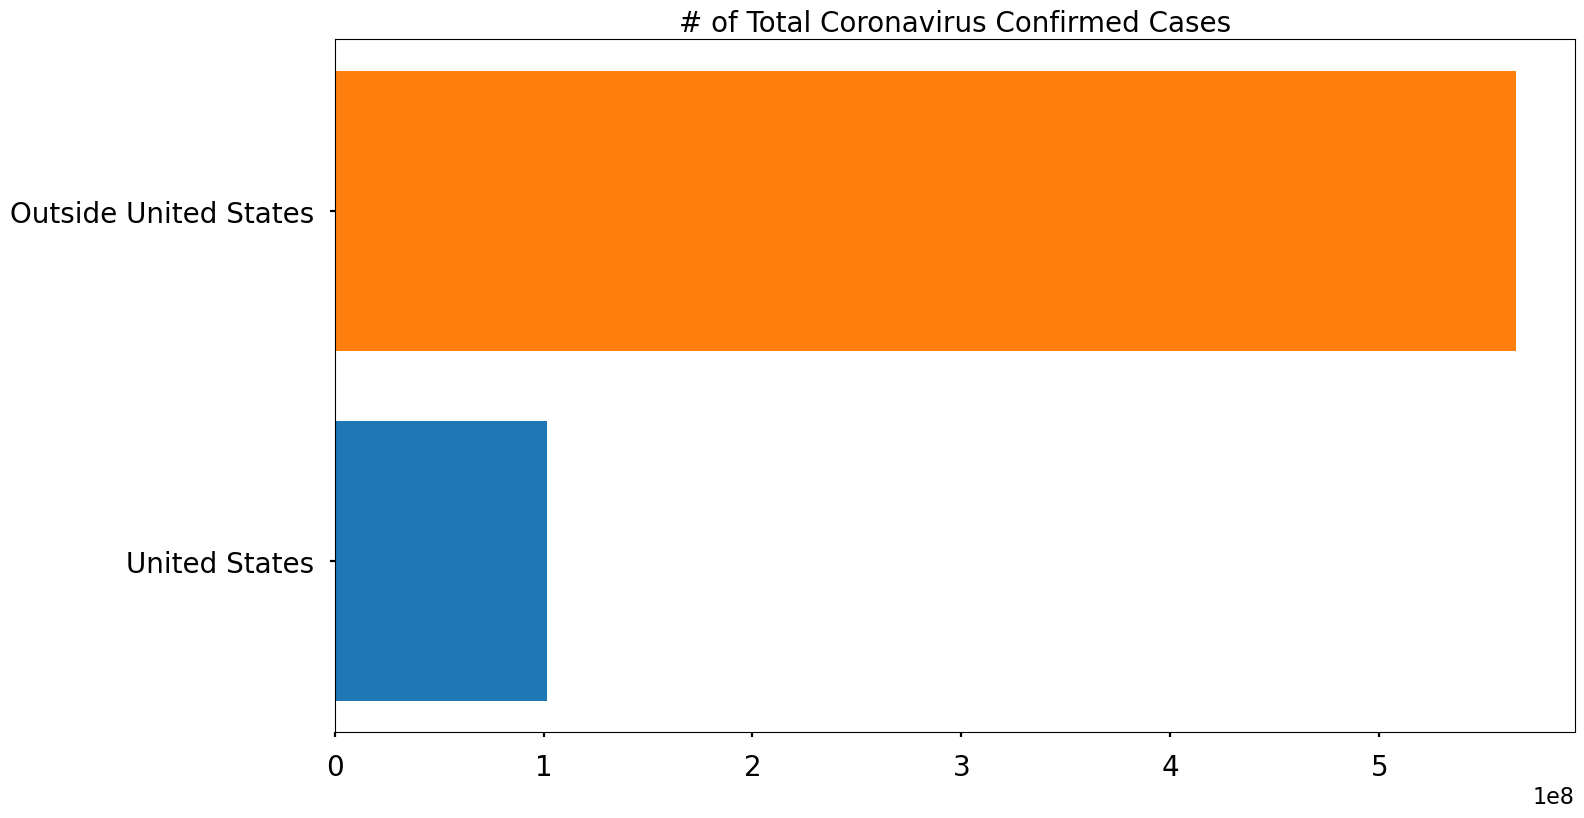

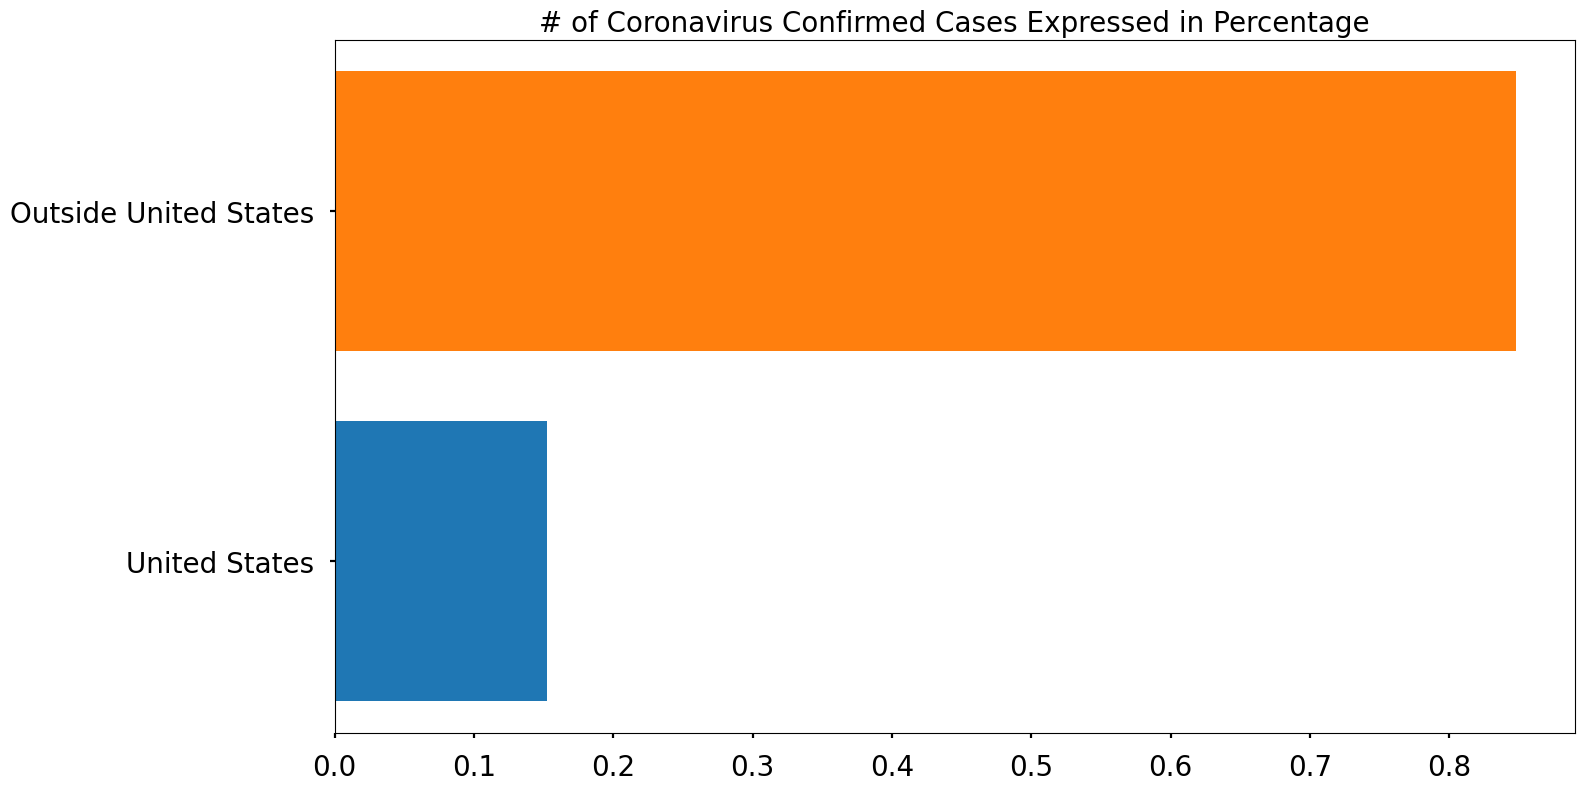

In [57]:
total_world_cases = np.sum(country_confirmed_cases)
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = total_world_cases - us_confirmed

plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed/total_world_cases)
plt.barh('Outside United States', outside_us_confirmed/total_world_cases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [58]:
print('Outside United States {} cases ({}%):'.format(outside_us_confirmed, np.round((outside_us_confirmed/total_world_cases)*100, 1)))
print('United States {} cases ({}%)'.format(us_confirmed, np.round((us_confirmed/total_world_cases)*100, 1)))
print('Total: {} cases'.format(total_world_cases))

Outside United States 565305945 cases (84.8%):
United States 101645683 cases (15.2%)
Total: 666951628 cases
